In [2]:
import pandas as pd
import pytz
import urllib3
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime, timedelta
import numpy as np
urllib3.disable_warnings()
import pandas as pd
import urllib3
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from datetime import datetime
from IPython.core.display import display, HTML
import matplotlib as mpl
from collections import OrderedDict
import numpy as np
from influxdb import InfluxDBClient as InfluxDBClient_old_version
from csv import DictReader
import os
import collections
import random
import json
import math
import requests
import io

import matplotlib
matplotlib.rcParams['timezone'] = 'US/Eastern'

pd.options.mode.chained_assignment = None  # default='warn'
display(HTML('<style>.container { width:100% !important; }</style>'))
mpl.rcParams['figure.dpi'] = 150
mpl.rcParams['figure.figsize'] = [24, 12]
plt.style.use('seaborn-whitegrid')
sns.set(font_scale=1.7)
sns.set_context("poster")
sns.set_style("whitegrid")
urllib3.disable_warnings()

import rx
from rx import operators as ops

from influxdb_client import InfluxDBClient, Point
from influxdb_client.client.write.retry import WritesRetry
from influxdb_client.client.write_api import SYNCHRONOUS
import geocoder
import glob
from influxdb_client.domain.write_precision import WritePrecision

import dataretrieval.nwis as nwis

C:\Users\sadhv\AppData\Local\Temp\ipykernel_20640\3167494877.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [3]:
client_old = InfluxDBClient_old_version(host='floodnet-influxdb.sonycproject.com', ssl=True, port=0, database='db0')

In [4]:
def pull_flood_data(_url='https://influxdb.floodnet.nyc',
                                    _token='rvEpEpb9bDwrb1NbmlbnmT4HT_XCQxeKn3DHghJu9uABrm1qbHhR9D8eXsoMux9v073wttFRY6FLs6FxM7TuSw==',
                                    _org='floodnet',
                                    dep_id=None,
                                    save_to_location=None,
                                    start_date=None,
                                    stop_date=None,):
    # TBD feature: query from start to stop date ranges passed as function arguments
    result = []
    
    start_date = pd.to_datetime(start_date, format='%Y-%m-%dT%H:%M:%S%z')
    stop_date = pd.to_datetime(stop_date, format='%Y-%m-%dT%H:%M:%S%z')
        
    p = {"_deployment_id": dep_id,
         "_start_date" : start_date, 
         "_stop_date" : stop_date,
        }

    with InfluxDBClient(url=_url, token=_token, org=_org, timeout=1000000) as client:
        query_api = client.query_api()
        query_string = '''from(bucket: "floodnet-live")
                                    |> range(start: _start_date, stop: _stop_date)
                                    |> filter(fn: (r) => r["_measurement"] == "flood-sensor")
                                    |> filter(fn: (r) => r["deployment_id"] == _deployment_id)
                                    |> pivot(rowKey: ["_time"], columnKey: ["_field"], valueColumn: "_value")
                                '''
        result = query_api.query_data_frame(query_string, params=p)
        if type(result) == list:
            result = pd.concat(result)

    result.drop(columns=['_start', '_stop', 'result', 'table'], inplace=True)
    result.rename(columns={'_time': 'time', '_measurement': 'measurement'}, inplace=True)
    result['time'] = pd.to_datetime(result['time'], format="%Y-%m-%d %H:%M:%S.%f", utc=True)
    result.set_index('time', inplace=True)
    result = result.sort_values(by=['time'])
    return result

In [5]:
df_ALL = pd.read_csv('../data/meta_data.csv')

In [6]:
def plot_usgs_and_tidal_sensors(st_date, en_date, st_datetime, en_datetime, dep_IDs):
    
    site = "01311875"

    usgs = nwis.get_record(sites = site, service ='iv', start=st_date, end=en_date)
    usgs = usgs.rename(columns = {"62620_navd88": "Tide Level"})
    usgs['date time'] = usgs.index

    x = np.array(usgs['date time'])
    y = np.array(usgs['Tide Level'])

    figure, ax_arry = plt.subplots(nrows=2, sharex=True, figsize=(24, 18))

    plt_count = 0

    for index, row in df_ALL.iterrows():
        
        if row['deployment_id'] in dep_IDs and dep_IDs[row['deployment_id']][0] == 0:

            dep_IDs[row['deployment_id']][0] += 1
            
            label = dep_IDs[row['deployment_id']][1]
            label2 = 'Tide Level'

            noaa_color = '#4e75a3'
            sensor_color = '#3d805a'

            df_flood = pull_flood_data(dep_id=row['deployment_id'], start_date=st_date, stop_date=en_date)
            df_flood['depth-feet'] = df_flood['depth_proc_mm'] / 25.4 / 12
            df_i = df_flood['depth-feet'].resample('1s').mean().interpolate(method='cubic', order=1)
        
            ax_arry[plt_count].set_xlim(pd.Timestamp(st_datetime), pd.Timestamp(en_datetime))
            ax2 = ax_arry[plt_count].twinx()

            ax_arry[plt_count].set_ylim(-4, 5)
            ax2.set_ylim(-0.8, 1)

            
            ax2.plot(df_i, color=sensor_color, label=label)
            ax_arry[plt_count].plot(x, y, color=noaa_color, label='Tide Level')
            ax_arry[plt_count].fill_between(x, y, color=noaa_color, alpha=0.1)

            ax_arry[plt_count].legend(framealpha=1, frameon=True, loc='upper left')
            ax2.legend(framealpha=1, frameon=True, loc='upper right')

            date_form = mdates.DateFormatter("%m/%d %H:%M")
            ax_arry[plt_count].xaxis.set_major_formatter(date_form)

            ax_arry[plt_count].set_ylabel('——— Tide Height (feet)', color=noaa_color)
            ax2.set_ylabel("——— Flood Depth (feet)", color=sensor_color)

            

            plt_count += 1

    plt.tight_layout(pad=1)
    plt.show()

In [7]:
dep_IDs = {'duly_pro_vervet': [0, "Russell St"], 'mildly_calm_ibex': [0, "Davenport Ct"]}

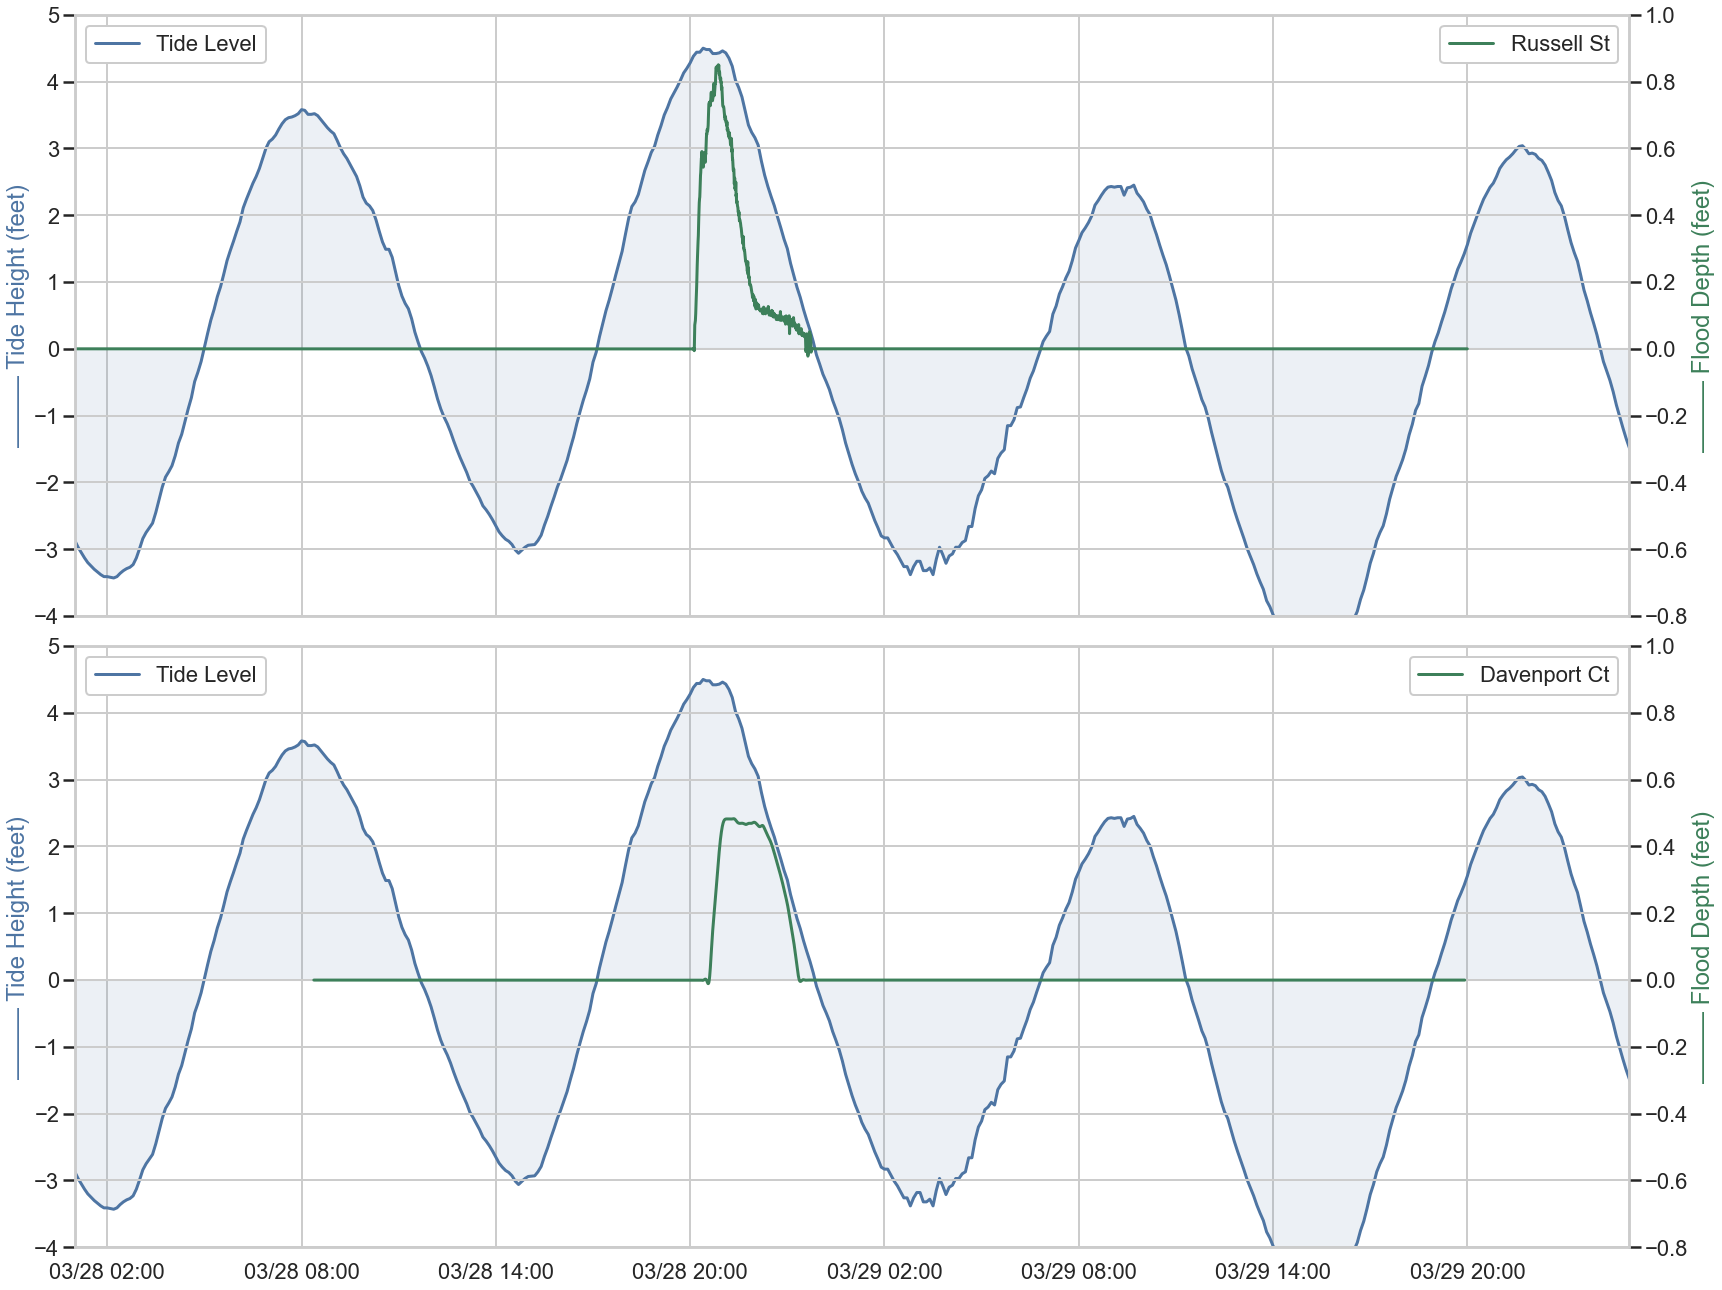

In [8]:
#USGS Tidal Data in Jamaica Bay from March 28th to March 30th 2021
plot_usgs_and_tidal_sensors('2021-03-28', '2021-03-30', '2021-03-28T00:00:00-05:00', '2021-03-30T00:00:00-05:00', dep_IDs)

C:\Users\sadhv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


(18714.208333333332, 18716.208333333332)

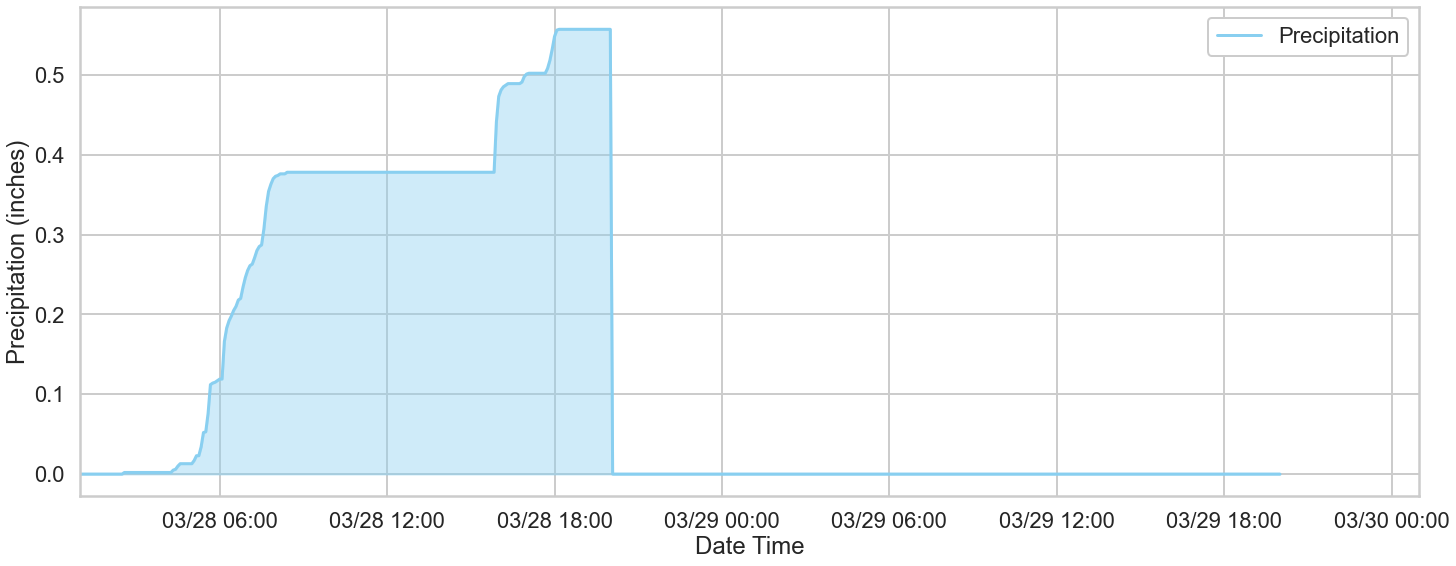

In [9]:
#Mesonet Rainfall Data 28th March to 30th March 2021
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20210328T0000/20210330T0000?stations=bknyrd&timezone=America/New_York')
misonet_weather_data = pd.read_csv(io.StringIO(r.text)) 
misonet_weather_data.rename(columns={'precip_local [inch]':'precip-inch', 'datetime':'local-time'}, inplace=True)
misonet_weather_data = misonet_weather_data.drop(columns=['avg_wind_speed_sonic [mi/hr]', 'max_wind_speed_sonic [mi/hr]',
       'wind_speed_stddev_sonic [mi/hr]', 'wind_direction_sonic [degrees]',
       'wind_direction_stddev_sonic [degrees]', 'avg_wind_speed_prop [mi/hr]',
       'max_wind_speed_prop [mi/hr]', 'wind_speed_stddev_prop [mi/hr]',
       'wind_direction_prop [degrees]', 'wind_direction_stddev_prop [degrees]',
       'solar_insolation [W/m^2]','temp_2m [degF]',
       'relative_humidity [percent]'])

misonet_weather_data['local-time'] = pd.to_datetime(misonet_weather_data['local-time'])


figure, ax_arry = plt.subplots(nrows=1, sharex=True, figsize=(24, 9))

rainfallColor = '#89CFF0'


x = np.array(misonet_weather_data['local-time'])
y = np.array(misonet_weather_data['precip-inch'])
ax_arry.plot(x,y,color=rainfallColor, label = 'Precipitation')
ax_arry.fill_between(x,y,color=rainfallColor,alpha = 0.4)

ax_arry.legend(framealpha=1, frameon=True, loc='upper right')


date_form = mdates.DateFormatter("%m/%d %H:%M")
ax_arry.xaxis.set_major_formatter(date_form)

ax_arry.set_xlabel('Date Time')
ax_arry.set_ylabel('Precipitation (inches)')

ax_arry.set_xlim(pd.Timestamp('2021-03-28T00:00:00-05:00'),pd.Timestamp('2021-03-30T00:00:00-05:00'))


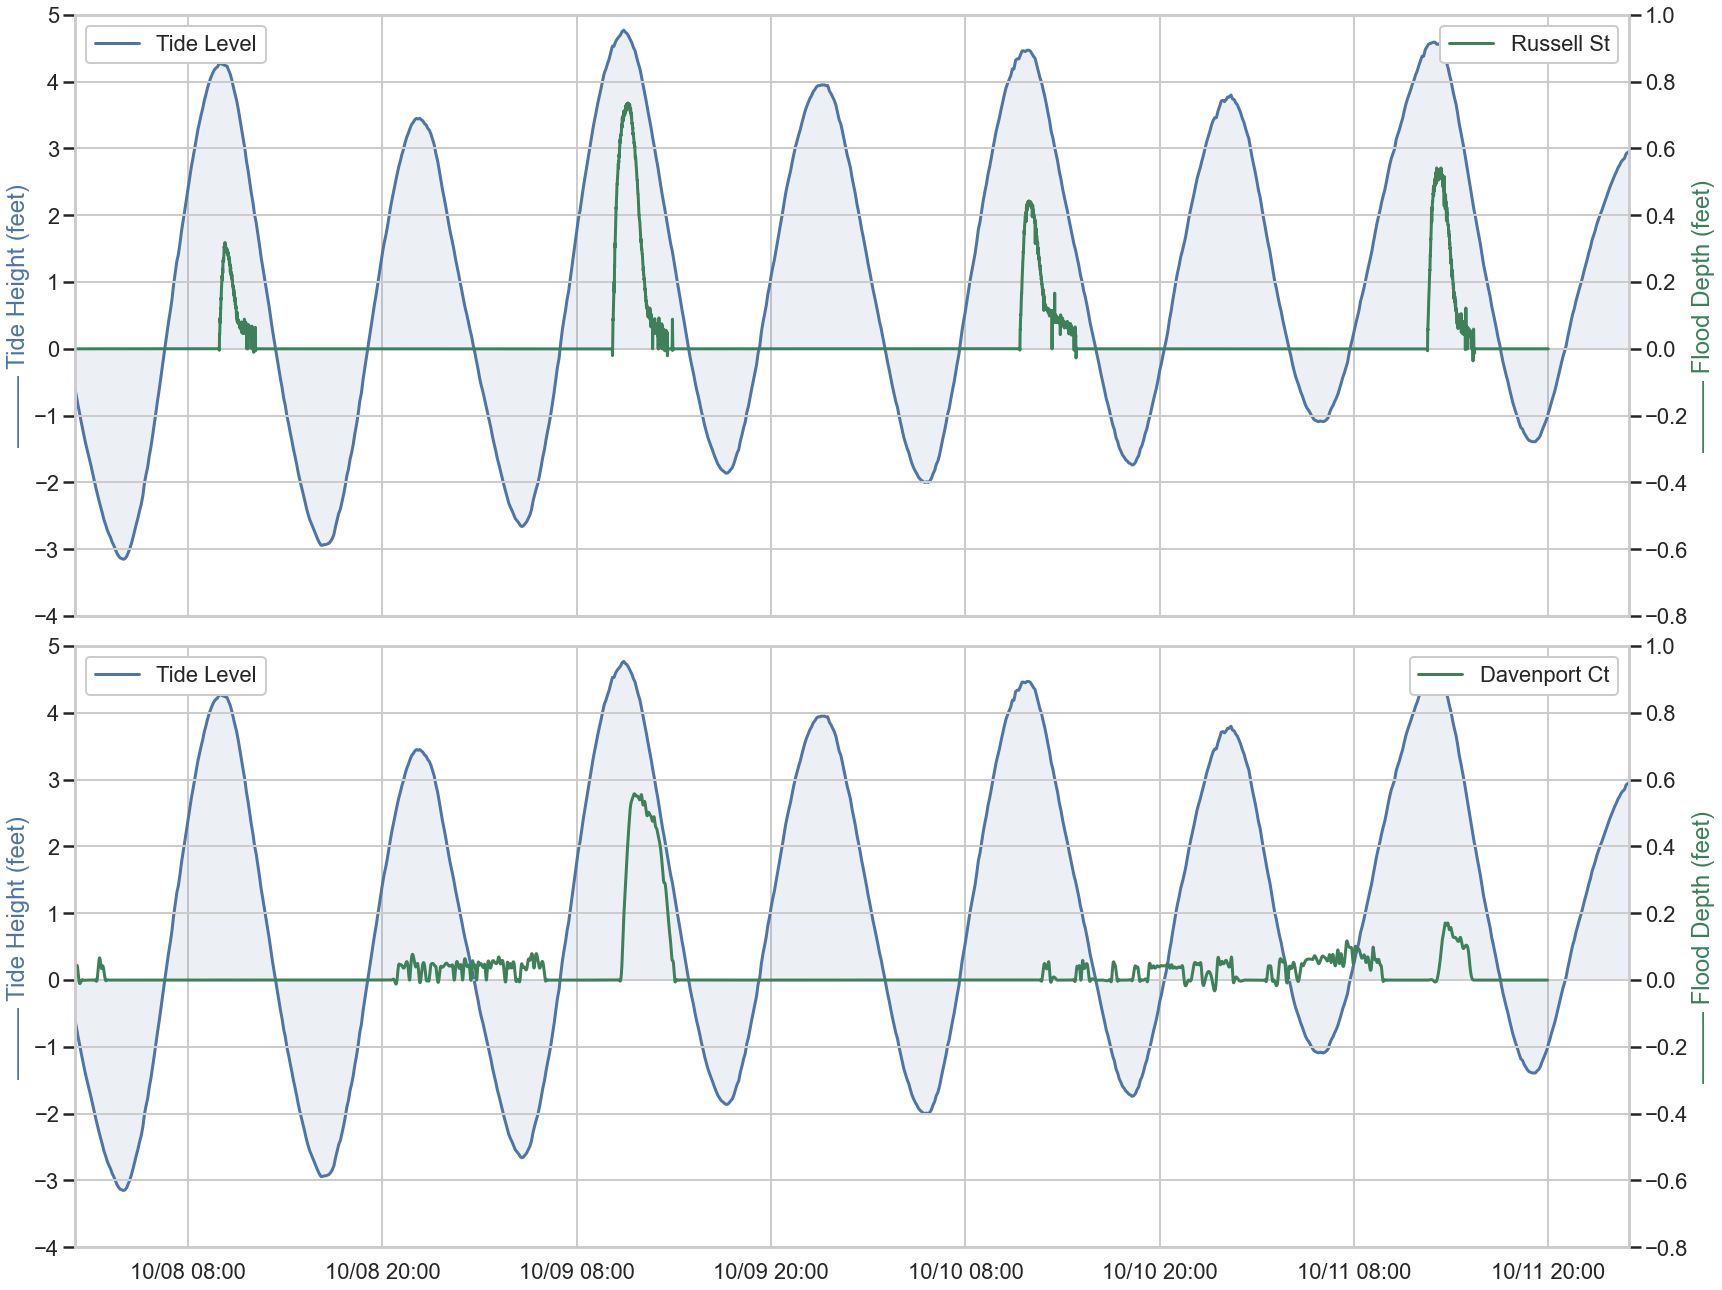

In [10]:
dep_IDs = {'duly_pro_vervet': [0, "Russell St"], 'mildly_calm_ibex': [0, "Davenport Ct"]}
#USGS Tidal Data in Jamaica Bay from 9th October 2021 to 12th October 2021
plot_usgs_and_tidal_sensors('2021-10-08', '2021-10-12', '2021-10-08T00:00:00-05:00', '2021-10-12T00:00:00-05:00', dep_IDs)

C:\Users\sadhv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


[0. 0. 0. ... 0. 0. 0.]


(18908.208333333332, 18912.208333333332)

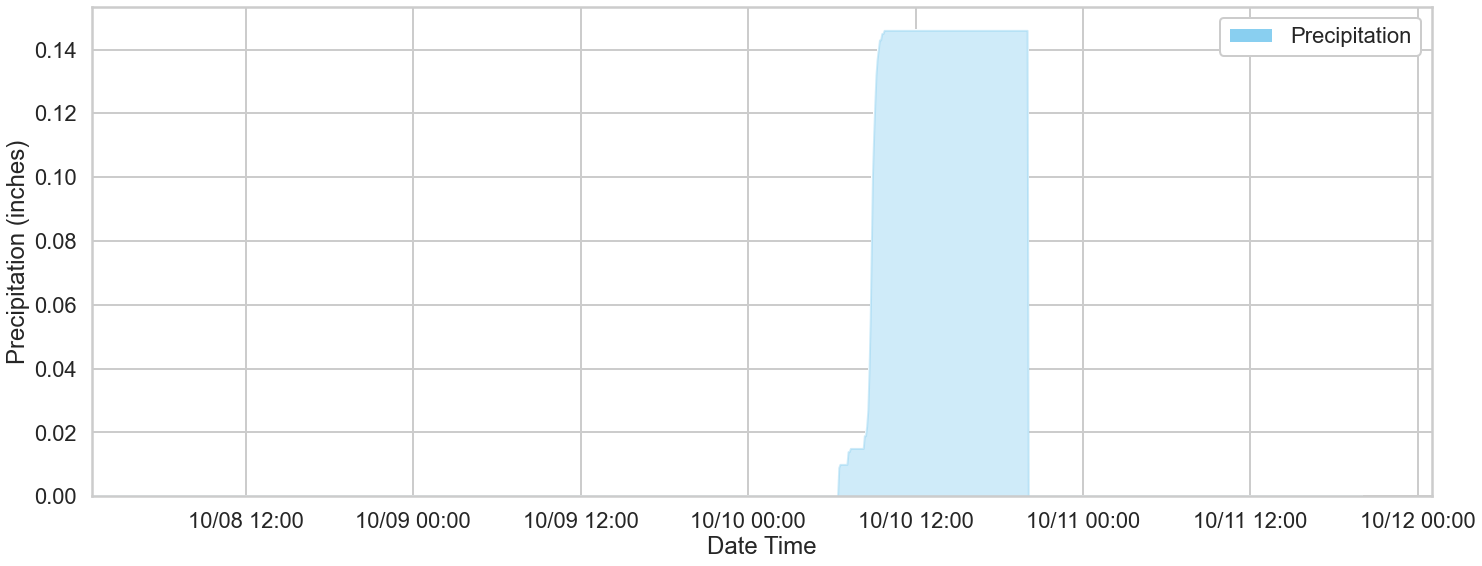

In [18]:
#Mesonet Rainfall Data 8th October to 12th October 2021
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20211008T0000/20211012T0000?stations=bknyrd&timezone=America/New_York')
misonet_weather_data = pd.read_csv(io.StringIO(r.text)) 
misonet_weather_data.rename(columns={'precip_local [inch]':'precip-inch', 'datetime':'local-time'}, inplace=True)
misonet_weather_data = misonet_weather_data.drop(columns=['avg_wind_speed_sonic [mi/hr]', 'max_wind_speed_sonic [mi/hr]',
       'wind_speed_stddev_sonic [mi/hr]', 'wind_direction_sonic [degrees]',
       'wind_direction_stddev_sonic [degrees]', 'avg_wind_speed_prop [mi/hr]',
       'max_wind_speed_prop [mi/hr]', 'wind_speed_stddev_prop [mi/hr]',
       'wind_direction_prop [degrees]', 'wind_direction_stddev_prop [degrees]',
       'solar_insolation [W/m^2]','temp_2m [degF]',
       'relative_humidity [percent]'])

misonet_weather_data['local-time'] = pd.to_datetime(misonet_weather_data['local-time'])


figure, ax_arry = plt.subplots(nrows=1, sharex=True, figsize=(24, 9))

rainfallColor = '#89CFF0'


x = np.array(misonet_weather_data['local-time'])
y = np.array(misonet_weather_data['precip-inch'])
print(y)
ax_arry.bar(x,height=y,color=rainfallColor, label = 'Precipitation', width=0.004)
ax_arry.fill_between(x,y,color=rainfallColor,alpha = 0.4)

ax_arry.legend(framealpha=1, frameon=True, loc='upper right')


date_form = mdates.DateFormatter("%m/%d %H:%M")
ax_arry.xaxis.set_major_formatter(date_form)

ax_arry.set_xlabel('Date Time')
ax_arry.set_ylabel('Precipitation (inches)')

ax_arry.set_xlim(pd.Timestamp('2021-10-08T00:00:00-05:00'),pd.Timestamp('2021-10-12T00:00:00-05:00'))



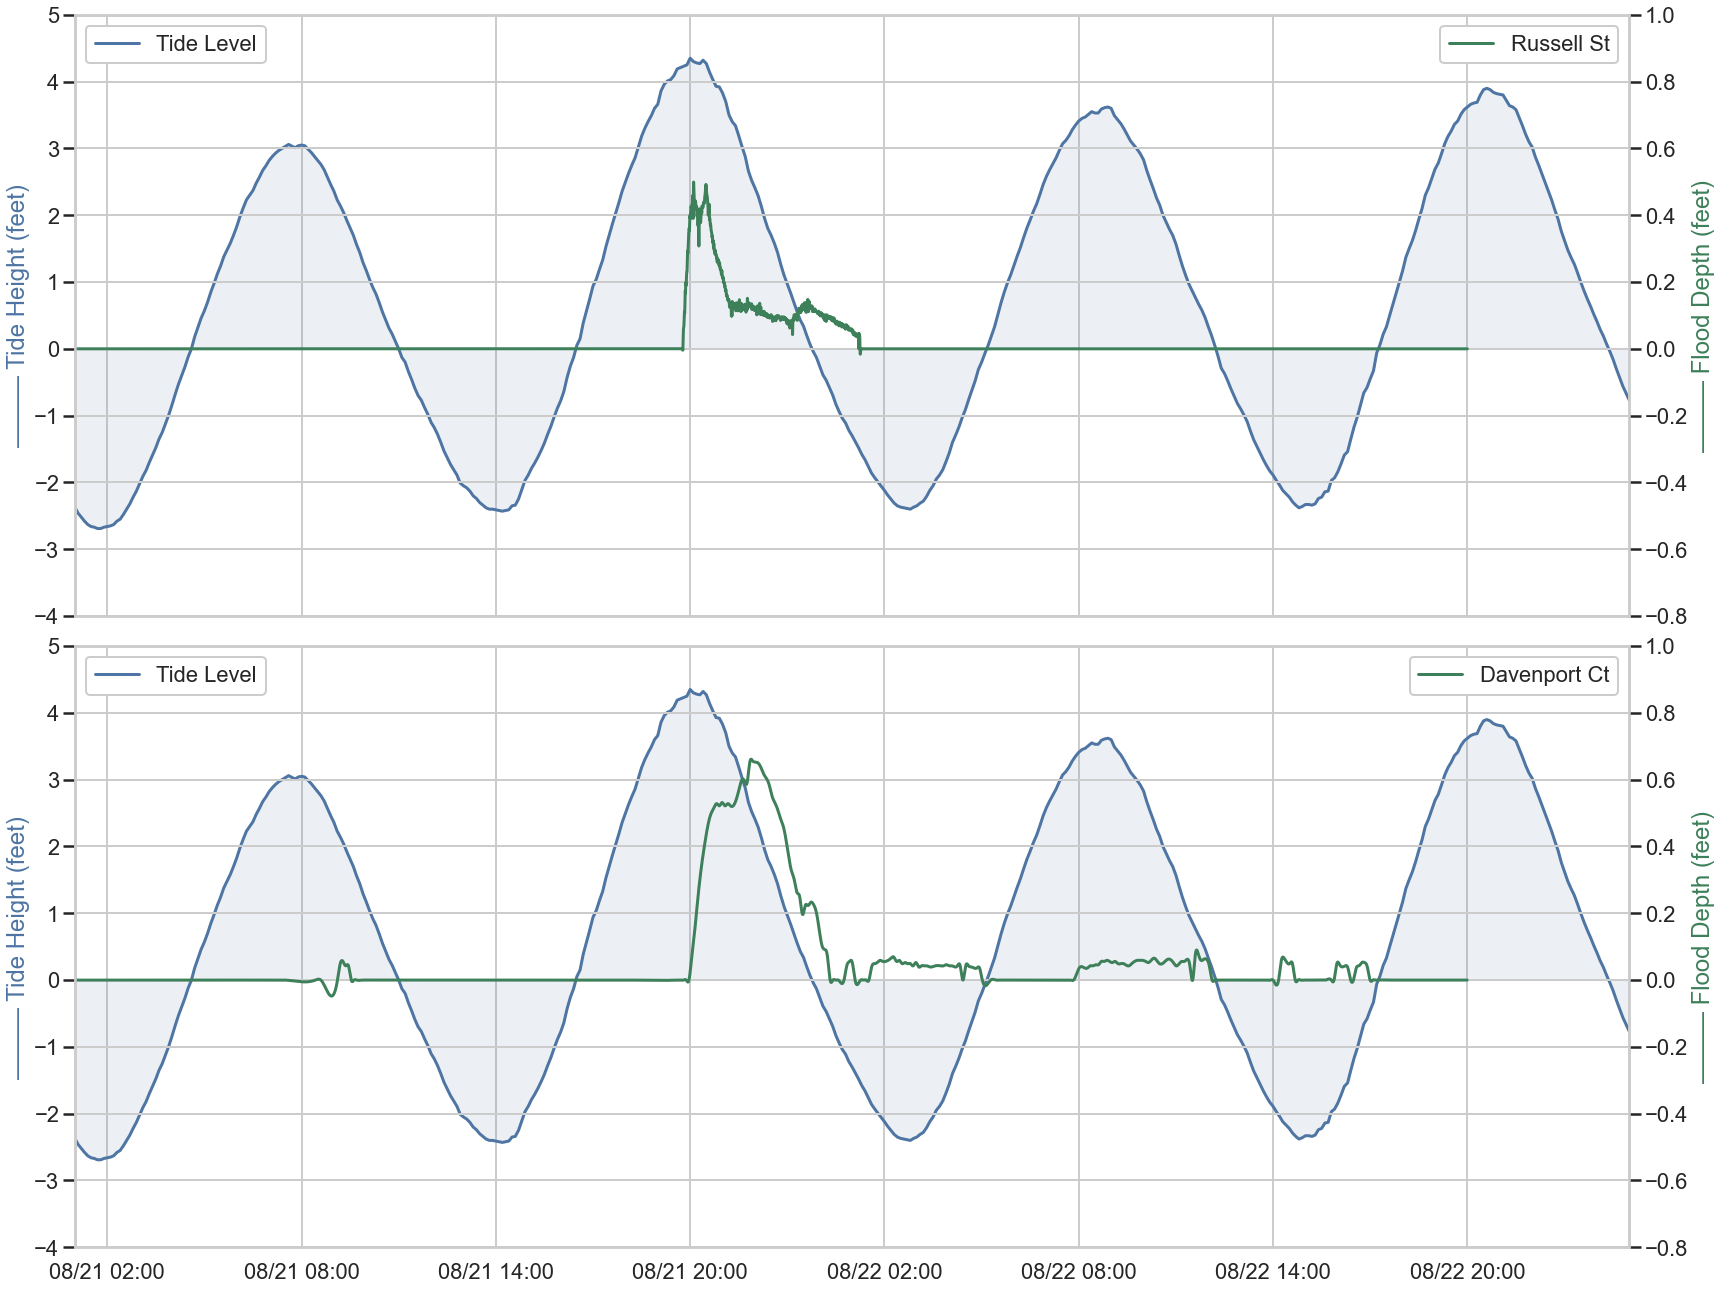

In [12]:
dep_IDs = {'duly_pro_vervet': [0, "Russell St"], 'mildly_calm_ibex': [0, "Davenport Ct"]}
#USGS Tidal Data in Jamaica Bay from 21st August 2021 to 23rd August 2021
plot_usgs_and_tidal_sensors('2021-08-21', '2021-08-23', '2021-08-21T00:00:00-05:00', '2021-08-23T00:00:00-05:00', dep_IDs)

C:\Users\sadhv\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\dateutil\parser\_parser.py:1207: UnknownTimezoneWarning: tzname EDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


Text(0, 0.5, 'Precipitation (inches)')

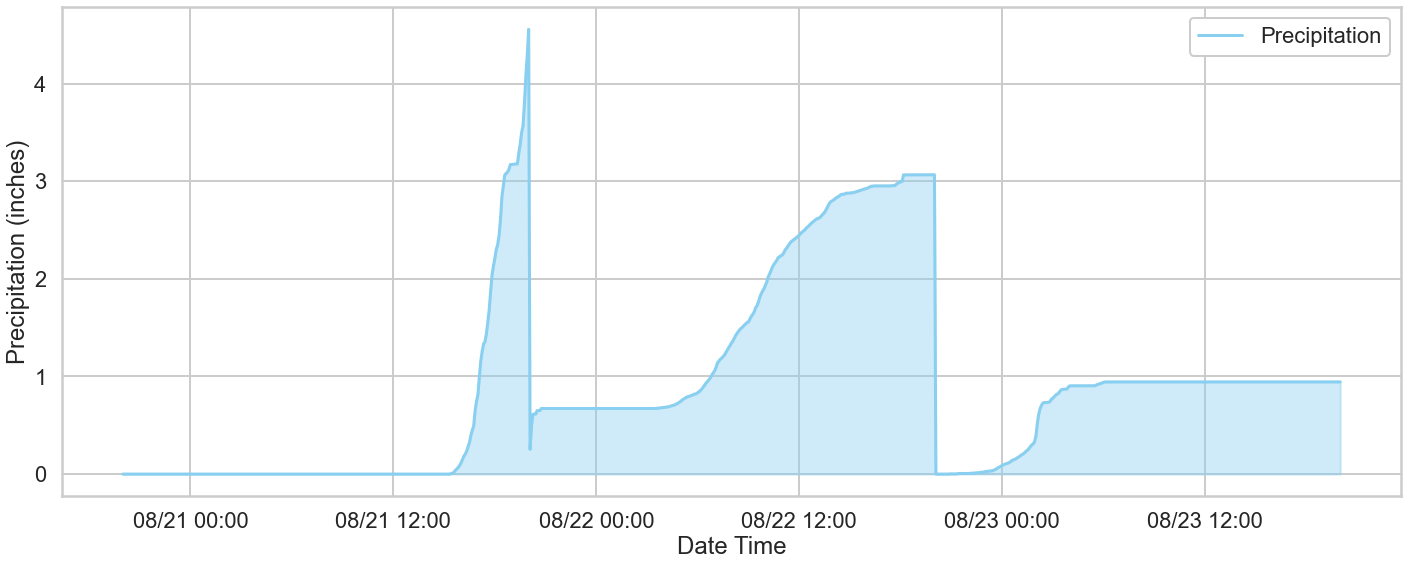

In [13]:
#Mesonet Rainfall Data 21st August to 24th August 2021
r = requests.get('https://api.nysmesonet.org/data/dynserv/coned/5min/nyc/20210821T0000/20210824T0000?stations=bknyrd&timezone=America/New_York')
misonet_weather_data = pd.read_csv(io.StringIO(r.text)) 
misonet_weather_data.rename(columns={'precip_local [inch]':'precip-inch', 'datetime':'local-time'}, inplace=True)
misonet_weather_data = misonet_weather_data.drop(columns=['avg_wind_speed_sonic [mi/hr]', 'max_wind_speed_sonic [mi/hr]',
       'wind_speed_stddev_sonic [mi/hr]', 'wind_direction_sonic [degrees]',
       'wind_direction_stddev_sonic [degrees]', 'avg_wind_speed_prop [mi/hr]',
       'max_wind_speed_prop [mi/hr]', 'wind_speed_stddev_prop [mi/hr]',
       'wind_direction_prop [degrees]', 'wind_direction_stddev_prop [degrees]',
       'solar_insolation [W/m^2]','temp_2m [degF]',
       'relative_humidity [percent]'])

misonet_weather_data['local-time'] = pd.to_datetime(misonet_weather_data['local-time'])


figure, ax_arry = plt.subplots(nrows=1, sharex=True, figsize=(24, 9))

rainfallColor = '#89CFF0'


x = np.array(misonet_weather_data['local-time'])
y = np.array(misonet_weather_data['precip-inch'])
ax_arry.plot(x,y,color=rainfallColor, label = 'Precipitation')
ax_arry.fill_between(x,y,color=rainfallColor,alpha = 0.4)

ax_arry.legend(framealpha=1, frameon=True, loc='upper right')


date_form = mdates.DateFormatter("%m/%d %H:%M")
ax_arry.xaxis.set_major_formatter(date_form)

ax_arry.set_xlabel('Date Time')
ax_arry.set_ylabel('Precipitation (inches)')
